# **Previsão básica de ações utilizando Multi Layer Perceptron**

- Diogo Nunes Batista
- Rafael de Oliveira Évora
- Vinicius Gabriel 

### Carregamento dos dados

In [4]:
import pandas 
import numpy as np

STOCK_NAME = 'CSNMineracao'

df = pandas.read_csv(f'data/final/{STOCK_NAME}.csv', index_col='DATA', sep=';', decimal='.')
df

,ABERTURA,FECHAMENTO,VARIAÇÃO,MÍNIMO,MÁXIMO,VOLUME,SELIC
DATA,,,,,,,
02/01/2024,0.0696,0.0704,0.10168,0.0691,0.0710,0.05515,0.043739
03/01/2024,0.0703,0.0713,0.10127,0.0696,0.0718,0.04610,0.043739
04/01/2024,0.0711,0.0701,0.09837,0.0680,0.0711,0.06905,0.043739
05/01/2024,0.0696,0.0701,0.10000,0.0687,0.0706,0.03739,0.043739
08/01/2024,0.0695,0.0691,0.09860,0.0684,0.0703,0.04757,0.043739
...,...,...,...,...,...,...,...
08/11/2024,0.0622,0.0585,0.09451,0.0584,0.0607,0.13190,0.041957
11/11/2024,0.0581,0.0577,0.09863,0.0570,0.0581,0.05002,0.041957
12/11/2024,0.0581,0.0555,0.09619,0.0554,0.0579,0.10470,0.041957


### Separação input e target

In [5]:
# input = [(df[i:i+7].values, np.array([df.iat[i+7, 0]])) for i in range(0, df.index.size - 7)]
N_DAYS = 7

input = np.array([(df[i:i+N_DAYS].to_numpy().flatten()) for i in range(df.index.size - N_DAYS)])
target = np.array([[df.iat[i+N_DAYS, 1]] for i in range(df.index.size - N_DAYS)])

N_TEST = 7

x_train = input[:-N_TEST]
t_train = target[:-N_TEST]

x_test = input[-N_TEST:]
t_test = target[-N_TEST:]

x_train.shape, t_train.shape, x_test.shape, t_test.shape

((208, 49), (208, 1), (7, 49), (7, 1))

### Treinamento

Test 0 finished with error: 0.15163748397498972 - epochs: 150000
params: {'learning_rate': 0.001, 'max_epochs': 150000, 'tolerated_error': 0.001}


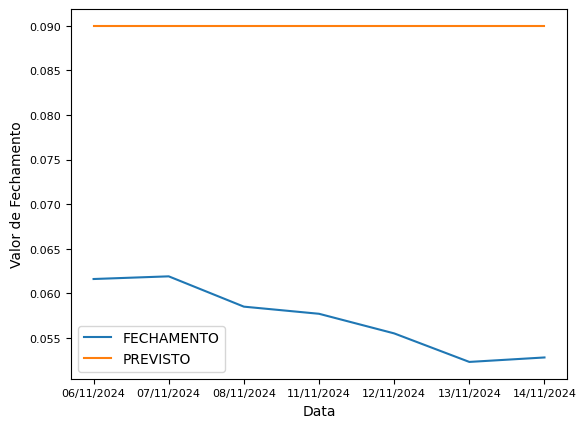

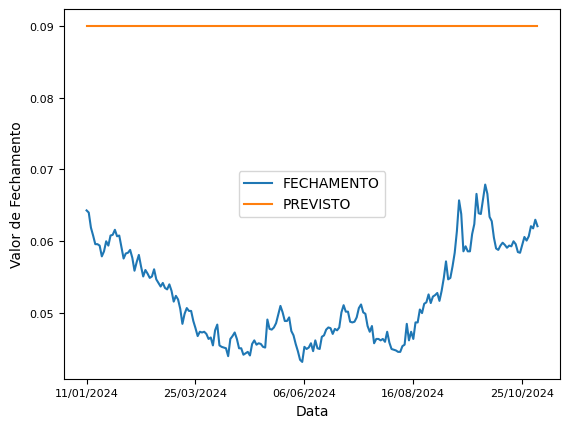

In [6]:
from mlp_model import MLP
from concurrent.futures import ThreadPoolExecutor

models = [
    MLP(layers_sizes=[49, 200, 150,25,5, 1], activation='sigmoid'),
    # MLP(layers_sizes=[49, 120, 120, 1], activation='sigmoid'),
    # MLP(layers_sizes=[49, 100, 100, 1], activation='tanh'),
    # MLP(layers_sizes=[49, 120, 120, 1], activation='tanh')
]

training_params = [
    {'learning_rate': 0.001, 'max_epochs': 150000, 'tolerated_error': 0.001},
    # {'learning_rate': 0.001, 'max_epochs': 10000, 'tolerated_error': 0.001},
    # {'learning_rate': 0.001, 'max_epochs': 10000, 'tolerated_error': 0.001},
    # {'learning_rate': 0.001, 'max_epochs': 10000, 'tolerated_error': 0.001}
]

def execute(i : int):
    mlp = models[i]
    # error, epochs = mlp.train(x_train, t_train, learning_rate=0.001, max_epochs=10000, tolerated_error=0.0001)
    error, epochs = mlp.train(x_train, t_train, **training_params[i])

    y_test = mlp.predict(x_test)

    y = mlp.predict(x_train)

    return y, y_test, error, epochs, training_params[i]

with ThreadPoolExecutor(max_workers=4) as executor:
    results = executor.map(execute, range(len(models)))

    for i, result in enumerate(results):
        y, y_test, error, epochs, params = result
        print(f'Test {i} finished with error: {error} - epochs: {epochs}')
        print(f'params: {params}')

        df_test = df.iloc[-N_TEST:].copy()
        df_test['PREVISTO'] = y_test

        df_test.plot(y=['FECHAMENTO', 'PREVISTO'], xlabel='Data', ylabel='Valor de Fechamento', fontsize=8).get_figure().savefig(f'results/{STOCK_NAME}_{i}.png')

        df_predict = df.iloc[N_DAYS:-N_TEST].copy()
        df_predict['PREVISTO'] = y

        df_predict.plot(y=['FECHAMENTO', 'PREVISTO'], xlabel='Data', ylabel='Valor de Fechamento', fontsize=8).get_figure().savefig(f'results/{STOCK_NAME}_test_{i}.png')
        